In [13]:
from astropy.io import fits
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tempfile
import imageio
from scipy import signal
import sprkls_pool as spkl
from importlib import reload
from scipy.optimize import curve_fit
import pandas as pd

# MagAO-X on-sky data

* Catagories for sparkle data: *

1) spark params: 600,	2000,	20,	0.03
<br>20221210 - 01:03:00 - WDMS-TYC-26-39-1
<br>20221212 - 06:05:40 - lab 
<br>- selfRM_sparkles_20221211_12_005.fits


2) spark params: 1800,  1800,   20, 0.015
<br>20221211 - 1:23:00 - TYC4865-1113-1
<br>20221212 - 5:46:40 - this has the wrong angle but the right frequencies
<br>- selfRM_TYC4865-1113-1_20221211_12_002.fits


3) spark params: 1800,	1800,   20, 0.015,  0
<br>20221212 - HD15115 - 1:52
<br>20221212 - lab - 6:35 
<br>- selfRM_sparkles_20221211_12_008.fits

In [14]:
# calibration files
dir_calib = '../data/calib/'
mask = 'aol1_wfsmask.fits'
ref = 'aol1_wfsref.fits'
dark = 'camwfs-dark_bin2_2000.000000_600.000000_-45.000000__T20220422005142597501326.fits'

## Param set 1: 12_10
spark params: 600,	2000,	20,	0.03
<br>- 20221210 - 01:03:00 - WDMS-TYC-26-39-1
<br>- 20221212 - 06:05:40 - lab 
<br>- selfRM_sparkles_20221211_12_005.fits


### Self RM data

In [ ]:
#self RM

### WFS data

In [40]:
# data directory work 
sky_dir_1210 = "/home/eden/data/2022B/12_10_spark_sky_WDMS-TYC/camwfs/"
lab_dir_1210 = "/home/eden/data/2022B/12_12_spark_selfRM/selfRM_sparkles_20221212T060539/camwfs/" # waiting for rsync to finish

#set up sparkle obj
reload(spkl)
sp_sky_1210 = spkl.Spark(sky_dir_1210, lab_dir_1210, dir_calib, dark, mask, ref, ref_norm = True)
sp_lab_1210 = spkl.Spark(lab_dir_1210, lab_dir_1210, dir_calib, dark, mask, ref, ref_norm = True)
# caching sparkle params
sp_sky_1210.set_spark_params()
sp_lab_1210.set_spark_params()

=> Sampling 100 files, starting at 0
100
HZ value: 600
HZ value: 600
=> Sampling 100 files, starting at 0
100
HZ value: 600
HZ value: 600
MOD : 1   TRIG : 1   FREQ : 2000   SEPS : 20   ANGS : 0   AMPS : 0.03   CROSS : 1  
MOD : 1   TRIG : 1   FREQ : 2000   SEPS : 20   ANGS : 0   AMPS : 0.03   CROSS : 1  
MOD : 1   TRIG : 1   FREQ : 2000   SEPS : 20   ANGS : 0   AMPS : 0.03   CROSS : 1  
MOD : 1   TRIG : 1   FREQ : 2000   SEPS : 20   ANGS : 0   AMPS : 0.03   CROSS : 1  


In [41]:
# changing the lab ref length because of the drop
sp_sky_1210.set_lab_ref(n_lab=80)
sp_lab_1210.set_lab_ref(n_lab=80)

=> Sampling 80 files, starting at 0
80
=> Sampling 80 files, starting at 0
80


In [55]:
# on sky dot products - with lab as the reference
data_sky_1210 = np.array(sp_sky_1210.dot_list_pool(n=10000, n_workers=40))
data_split_1210 = np.array(spkl.split_data_roll(data_sky_1210))
# lab dot products - with lab as the reference
data_lab_1210 = np.array(sp_lab_1210.dot_list_pool(n=10000, n_workers=40))
data_split_l_1210 = np.array(spkl.split_data_roll(data_lab_1210))

chunksize=250, n_workers=40
chunksize=250, n_workers=40


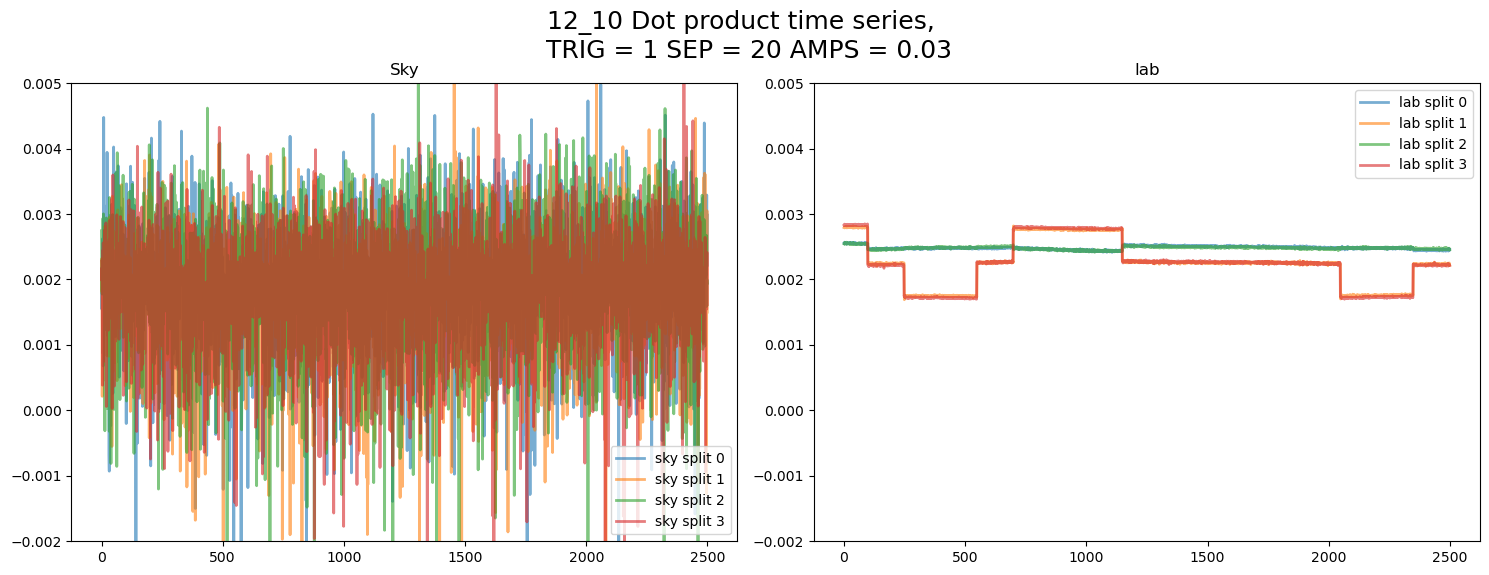

In [60]:
# Both datasets, same plot
# define subplot grid
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), facecolor='white')
plt.subplots_adjust(hspace=0.5)
title_long = f"12_10 Dot product time series, \n TRIG = {sp_sky_1210.data_spark_params['TRIG']} SEP = {sp_sky_1210.data_spark_params['SEPS']} AMPS = {sp_sky_1210.lab_spark_params['AMPS']}"
fig.suptitle(title_long, fontsize=18, y=0.95)

axs_r = axs.ravel()

# plot raw values
for e in range(4):
    axs_r[0].plot(data_split_1210[e], lw=2, alpha = 0.6, label = f'sky split {e}')
# chart formatting
axs_r[0].set_ylim(top=0.005, bottom=-0.002)
axs_r[0].set_title(f"Sky")
axs_r[0].legend()

# plot ratios
for e in range(4):
    axs_r[1].plot(data_split_l_1210[e], lw=2, alpha = 0.6, label = f'lab split {e}')
# chart formatting
axs_r[1].set_ylim(top=0.005, bottom=-0.002)
axs_r[1].set_title(f"lab")
axs_r[1].legend()

plt.tight_layout()
plt.show()

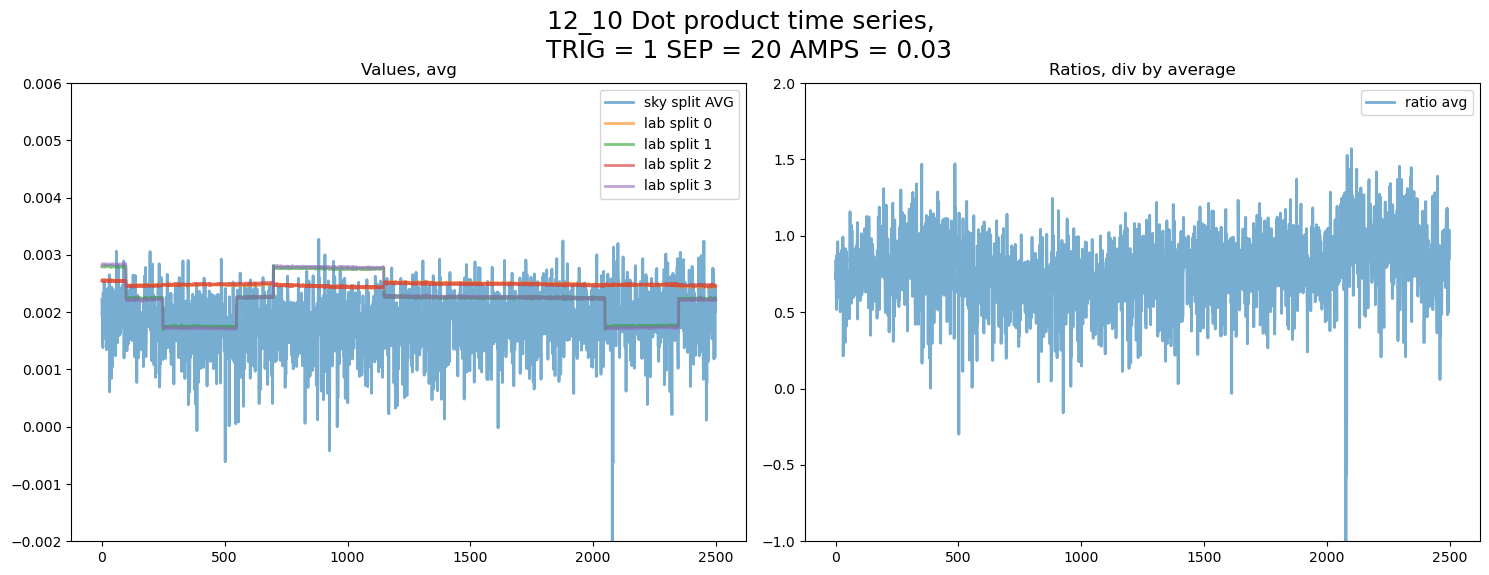

In [57]:
# Both datasets, same plot, averages

# define subplot grid
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), facecolor='white')
plt.subplots_adjust(hspace=0.5)
title_long = f"12_10 Dot product time series AVG, \n TRIG = {sp_sky_1210.data_spark_params['TRIG']} SEP = {sp_sky_1210.data_spark_params['SEPS']} AMPS = {sp_sky_1210.lab_spark_params['AMPS']}"
fig.suptitle(title_long, fontsize=18, y=0.95)

axs_r = axs.ravel()

# plot raw values
axs_r[0].plot(np.average(data_split_1210, axis=0), lw=2, alpha = 0.6, label = f'sky split AVG')
for e in range(4):
    axs_r[0].plot(data_split_l_1210[e], lw=2, alpha = 0.6, label = f'lab split {e}')
# chart formatting
axs_r[0].set_ylim(top=0.006, bottom=-0.002)
axs_r[0].set_title(f"Values, avg")
axs_r[0].legend()

# plot ratios
plot_average = np.average(np.divide(data_split_1210,data_split_l_1210), axis=0)
axs_r[1].plot(plot_average, lw=2, alpha = 0.6, label = f'ratio avg')
# chart formatting
axs_r[1].set_ylim(top=2, bottom=-1)
axs_r[1].set_title(f"Ratios, div by average")
axs_r[1].legend()

plt.tight_layout()
plt.show()

### Old reduction...

In [73]:
# sample both on sky and lab 
n=10000

s_data_cube, s_start, s_frame_list, s_wrt_list = spkl.file_sample(n, sky_f_list, sky_dir_1210)
l_data_cube, l_start, l_frame_list, l_wrt_list = spkl.file_sample(n, lab_f_list, lab_dir_1210)

# check continuous
print("Sky: start n = ", s_start, ', Continuous? ', spkl.check_cont(s_frame_list, s_wrt_list, Hz=600))
print("Lab: start n = ", l_start, ', Continuous? ', spkl.check_cont(l_frame_list, l_wrt_list, Hz=600))

In [75]:
# clean and split both sky and lab
reload(spkl)

# cleaning
s_mat_ref_sub, dark_mat, mask_mat, ref_mat, ref_normed = spkl.clean_data_cube(s_data_cube, calib_path, dark, mask, ref)
l_mat_ref_sub, _, _, _, _ = spkl.clean_data_cube(l_data_cube, calib_path, dark, mask, ref)

# splitting
s_arr_clean = spkl.split_data_sub(s_mat_ref_sub)
l_arr_clean = spkl.split_data_sub(l_mat_ref_sub)

# NAN matrix for fun other things
mask_nan = mask_mat.copy()
mask_nan[mask_nan == 0] = np.nan
mask_nan_0 = mask_nan[0,:,:]
mask_split = spkl.split_data_sub(mask_nan)

In [77]:
# dot product of the average with each individual frame
reload(spkl)
n_roll = 100

# lab data: dot product with own data
l_dot_mat = spkl.return_dot_mat(l_arr_clean, l_arr_clean)
l_dot_avgs, l_dot_stds = spkl.return_rolling(l_dot_mat, n=n_roll)

# sky data: dot product with lab data, see how it compares
s_dot_mat = spkl.return_dot_mat(s_arr_clean, l_arr_clean) #dotting lab with sky
s_dot_avgs, s_dot_stds = spkl.return_rolling(s_dot_mat, n=n_roll)

In [89]:
np.nanmean(l_arr_clean[e], axis=(1,2)).shape

(2500,)

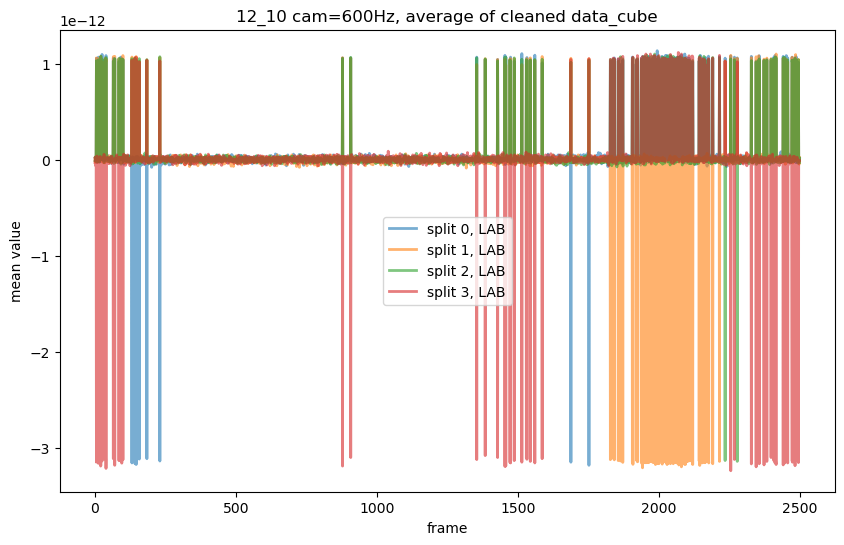

In [90]:
fig = plt.figure(figsize=(10,6), facecolor='white')
l_arr_clean = np.array(l_arr_clean)
for e, mat in enumerate(l_dot_avgs):
    plt.plot(np.nanmean(l_arr_clean[e], axis=(1,2)), lw=2, alpha = 0.6, label = f'split {e}, LAB')

plt.legend()
plt.xlabel('frame')
plt.ylabel('mean value')
plt.title("12_10 cam=600Hz, average of cleaned data_cube")
plt.show()

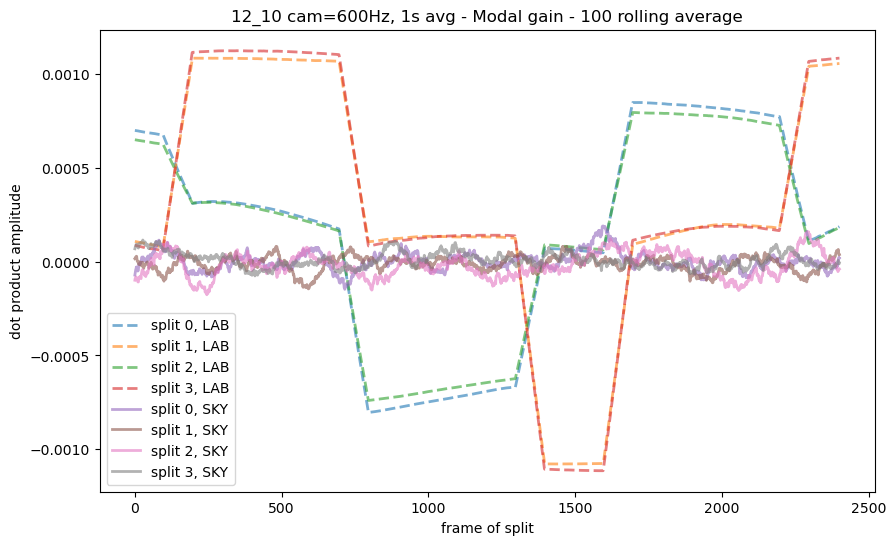

In [57]:
# compare lab with onsky datasets
fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(l_dot_avgs):
    plt.plot(l_dot_avgs[e], lw=2, linestyle='dashed', alpha = 0.6, label = f'split {e}, LAB')
    #plt.fill_between(np.arange(len(l_dot_avgs[e])), l_dot_avgs[e]-l_dot_stds[e], l_dot_avgs[e]+l_dot_stds[e], alpha=0.2)

for e, mat in enumerate(s_dot_avgs):
    plt.plot(s_dot_avgs[e], lw=2, alpha = 0.6, label = f'split {e}, SKY')
    #plt.fill_between(np.arange(len(s_dot_avgs[e])), s_dot_avgs[e]-s_dot_stds[e], s_dot_avgs[e]+s_dot_stds[e], alpha=0.2)

plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title("12_10 cam=600Hz, 1s avg - Modal gain - 100 rolling average")
plt.show()

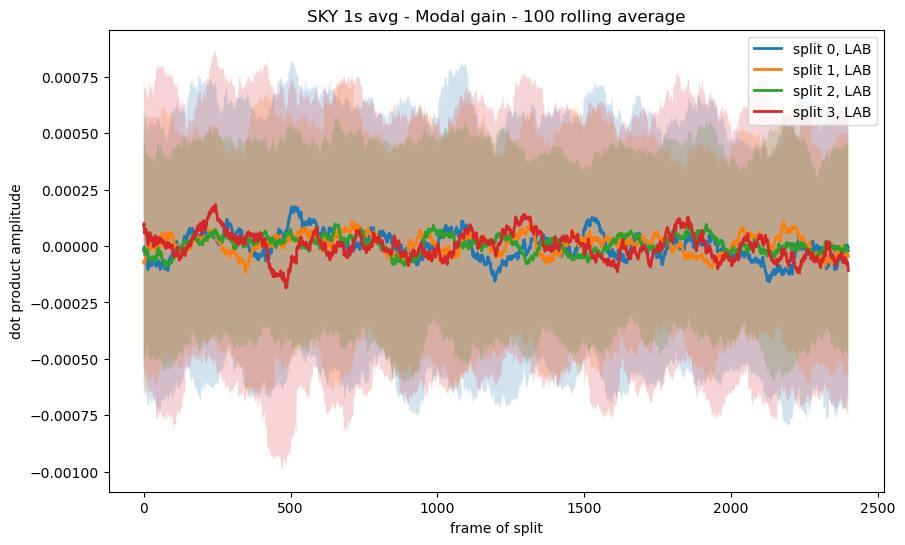

In [37]:
# Displaying lab splits - modal projections
fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(s_dot_avgs):
    plt.plot(s_dot_avgs[e], lw=2, label = f'split {e}, LAB')
    plt.fill_between(np.arange(len(s_dot_avgs[e])), s_dot_avgs[e]-s_dot_stds[e], s_dot_avgs[e]+s_dot_stds[e], alpha=0.2)

plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title("SKY 1s avg - Modal gain - 100 rolling average")
plt.show()

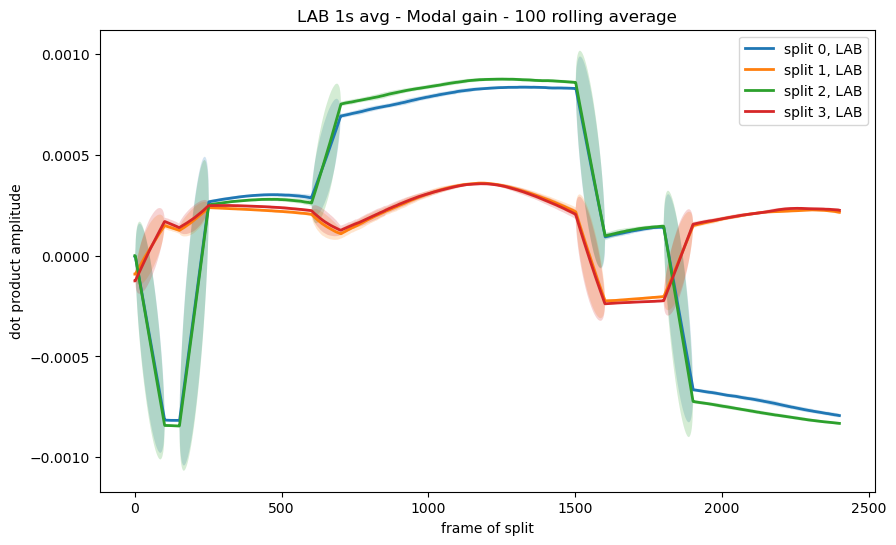

In [38]:
# Displaying lab splits - modal projections
fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(l_dot_avgs):
    plt.plot(l_dot_avgs[e], lw=2, label = f'split {e}, LAB')
    plt.fill_between(np.arange(len(l_dot_avgs[e])), l_dot_avgs[e]-l_dot_stds[e], l_dot_avgs[e]+l_dot_stds[e], alpha=0.2)

plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title("LAB 1s avg - Modal gain - 100 rolling average")
plt.show()

## Param Set 2: 12_11
spark params: 1800,  1800,   20, 0.015
<br>- 20221211 - 1:23:00 - TYC4865-1113-1
<br>- 20221212 - 5:46:40 - this has the wrong angle but the right frequencies
<br>- selfRM_TYC4865-1113-1_20221211_12_002.fits

In [14]:
# data directory work 
sky_dir_1213 = "/home/eden/data/2022B/spark_test_12_10/spark_sky_data/camwfs/"
lab_dir_1213 = "/home/eden/data/2022B/spark_test_12_12_selfRM/selfRM_sparkles_20221212T063523/camwfs/" 

In [ ]:
# data directory work 
sky_dir_1210 = "/home/eden/data/2022B/12_10_spark_sky_WDMS-TYC/camwfs/"
lab_dir_1213 = "/home/eden/data/2022B/spark_test_12_12_selfRM/selfRM_sparkles_20221212T063523/camwfs/" 

#set up sparkle obj
reload(spkl)
sp_sky_1213 = spkl.Spark(sky_dir_1213, lab_dir_1213, dir_calib, dark, mask, ref, ref_norm = True)
sp_lab_1213 = spkl.Spark(lab_dir_1213, lab_dir_1213, dir_calib, dark, mask, ref, ref_norm = True)
# caching sparkle params
sp_sky_1213.set_spark_params()
sp_lab_1213.set_spark_params()

In [ ]:
#set up sparkle obj
reload(spkl)
sp_sky_1211= spkl.Spark(sky_dir_1210, lab_dir_1210, dir_calib, dark, mask, ref, ref_norm = True)
sp_lab_1210= spkl.Spark(lab_dir_1210, lab_dir_1210, dir_calib, dark, mask, ref, ref_norm = True)

In [ ]:
# on sky dot products - with lab as the reference
data_sky_1210 = np.array(sp_sky_1210.dot_list_pool(n=100000, n_workers=40))
# Sky splits
data_split_1210 = [data_sky_1210[i::4,i] for i in range(4)]

# lab
# on sky dot products - with lab as the reference
data_lab_1210 = np.array(sp_lab_1210.dot_list_pool(n=100000, n_workers=40))
# Sky splits
data_split_l_1210 = [data_lab_1210[i::4,i] for i in range(4)]

### Old Reduction ...

In [ ]:
# Retrieve file lists
sky_f_list = spkl.return_files(sky_dir_1213)
lab_f_list = spkl.return_files(lab_dir_1213)

In [22]:
# sample both on sky and lab 
n=10000
un_Hz=1800

s_data_cube, s_start, s_frame_list, s_wrt_list = spkl.file_sample(n, sky_f_list, sky_dir_1213, n_start = 1)
l_data_cube, l_start, l_frame_list, l_wrt_list = spkl.file_sample(n, lab_f_list, lab_dir_1213, n_start = 1)

# check continuous
print("Sky: start n = ", s_start, ', Continuous? ', spkl.check_cont(s_frame_list, s_wrt_list, Hz=un_Hz))
print("Lab: start n = ", l_start, ', Continuous? ', spkl.check_cont(l_frame_list, l_wrt_list, Hz=un_Hz))

Sky: start n =  1 , Continuous?  False
Lab: start n =  1 , Continuous?  True


In [23]:
# clean and split both sky and lab
reload(spkl)

# cleaning
s_mat_ref_sub, dark_mat, mask_mat, ref_mat, ref_normed = spkl.clean_data_cube(s_data_cube, calib_path, dark, mask, ref)
l_mat_ref_sub, _, _, _, _ = spkl.clean_data_cube(l_data_cube, calib_path, dark, mask, ref)

# splitting
s_arr_clean = spkl.split_data_sub(s_mat_ref_sub)
l_arr_clean = spkl.split_data_sub(l_mat_ref_sub)

# NAN matrix for fun other things
mask_nan = mask_mat.copy()
mask_nan[mask_nan == 0] = np.nan
mask_nan_0 = mask_nan[0,:,:]
mask_split = spkl.split_data_sub(mask_nan)

In [24]:
# dot product of the average with each individual frame
reload(spkl)
n_roll = 100

# lab data: dot product with own data
l_dot_mat = spkl.return_dot_mat(l_arr_clean, l_arr_clean)
l_dot_avgs, l_dot_stds = spkl.return_rolling(l_dot_mat, n=n_roll)

# sky data: dot product with lab data, see how it compares
s_dot_mat = spkl.return_dot_mat(s_arr_clean, l_arr_clean) #dotting lab with sky
s_dot_avgs, s_dot_stds = spkl.return_rolling(s_dot_mat, n=n_roll)

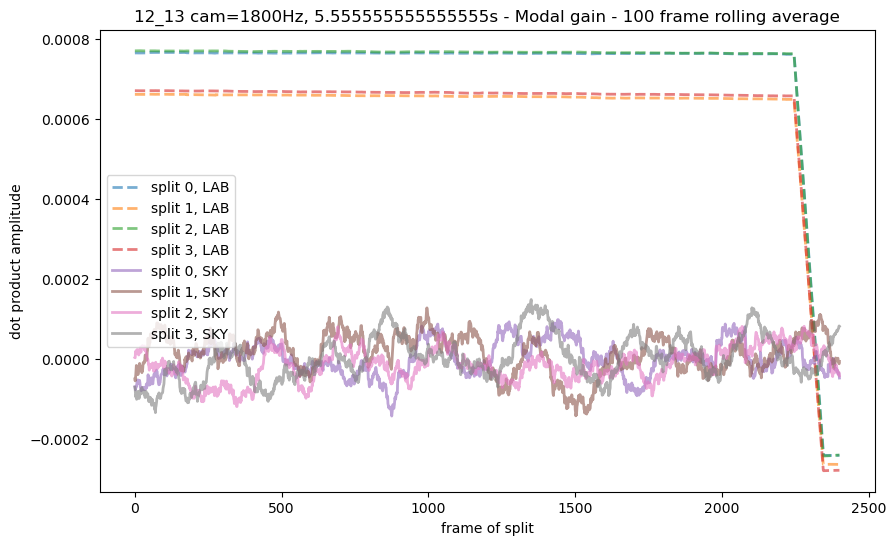

In [27]:
# compare lab with onsky datasets
fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(l_dot_avgs):
    plt.plot(l_dot_avgs[e], lw=2, linestyle='dashed', alpha = 0.6, label = f'split {e}, LAB')
    #plt.fill_between(np.arange(len(l_dot_avgs[e])), l_dot_avgs[e]-l_dot_stds[e], l_dot_avgs[e]+l_dot_stds[e], alpha=0.2)

for e, mat in enumerate(s_dot_avgs):
    plt.plot(s_dot_avgs[e], lw=2, alpha = 0.6, label = f'split {e}, SKY')
    #plt.fill_between(np.arange(len(s_dot_avgs[e])), s_dot_avgs[e]-s_dot_stds[e], s_dot_avgs[e]+s_dot_stds[e], alpha=0.2)

plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title(f"12_13 cam=1800Hz, {n/un_Hz}s - Modal gain - 100 frame rolling average")
plt.show()

In [35]:
# trying another dot product method:
def return_dot_mat_first(splits_arr, mean_arr):
    mean_splts_arr = np.array([meansplit[0, :, :] for meansplit in mean_arr])
    mean_splts_arr_norm = np.array([avg_split/np.linalg.norm(avg_split.flatten())for avg_split in mean_splts_arr])
    dot_mat = np.array([[np.dot(mean_splts_arr_norm[e].flatten(), array.flatten()) for array in split] for e, split in enumerate(splits_arr)])
    return dot_mat

def return_dot_mat_limit(splits_arr, mean_arr, n=100):
    mean_array = [meansplit[0:n] for meansplit in mean_arr]
    mean_splts_arr = np.nanmean(mean_array, axis=1)
    mean_splts_arr_norm = np.array([avg_split/np.linalg.norm(avg_split.flatten())for avg_split in mean_splts_arr])
    dot_mat = np.array([[np.dot(mean_splts_arr_norm[e].flatten(), array.flatten()) for array in split] for e, split in enumerate(splits_arr)])
    return dot_mat

In [37]:
l_dot_mat_first = return_dot_mat_first(l_arr_clean, l_arr_clean)
l_dot_mat_mid = return_dot_mat_limit(l_arr_clean, l_arr_clean)

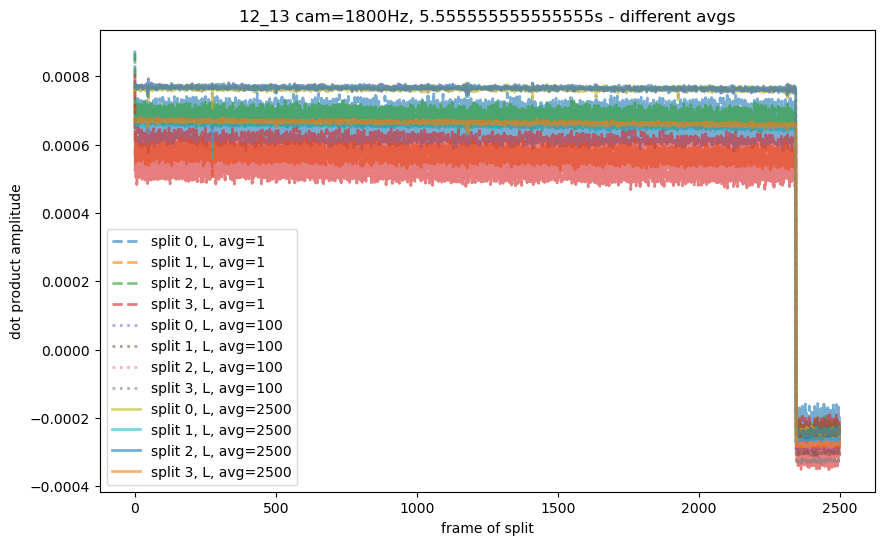

In [39]:
# compare lab with onsky datasets
fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(l_dot_avgs):
    plt.plot(l_dot_mat_first[e], lw=2, linestyle='dashed', alpha = 0.6, label = f'split {e}, L, avg=1')
    
for e, mat in enumerate(l_dot_mat_mid):
    plt.plot(l_dot_mat_mid[e], lw=2, linestyle='dotted', alpha = 0.6, label = f'split {e}, L, avg=100')

for e, mat in enumerate(l_dot_mat):
    plt.plot(l_dot_mat[e], lw=2, alpha = 0.6, label = f'split {e}, L, avg=2500')
    
plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title(f"12_13 cam=1800Hz, {n/un_Hz}s - different avgs")
plt.show()

### long time split

In [41]:
# sample both on sky and lab 
n=100000
un_Hz=1800

l_data_cube, l_start, l_frame_list, l_wrt_list = spkl.file_sample(n, lab_f_list, lab_dir_1213, n_start = 1)

# check continuous
print("Lab: start n = ", l_start, ', Continuous? ', spkl.check_cont(l_frame_list, l_wrt_list, Hz=un_Hz))

Lab: start n =  1 , Continuous?  True


In [42]:
l_mat_ref_sub, _, _, _, _ = spkl.clean_data_cube(l_data_cube, calib_path, dark, mask, ref)
l_arr_clean = spkl.split_data_sub(l_mat_ref_sub)

In [43]:
l_dot_mat_first = return_dot_mat_first(l_arr_clean, l_arr_clean)

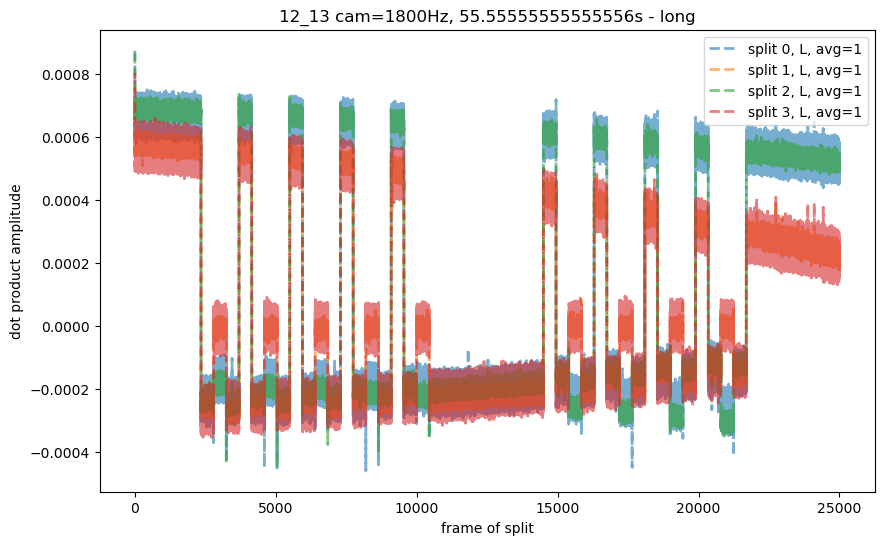

In [44]:
# compare lab with onsky datasets
fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(l_dot_avgs):
    plt.plot(l_dot_mat_first[e], lw=2, linestyle='dashed', alpha = 0.6, label = f'split {e}, L, avg=1')
    
plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title(f"12_13 cam=1800Hz, {n/un_Hz}s - long")
plt.show()

### and then the non triggered data

In [51]:
lab_dir_1213_nt = "/home/eden/data/2022B/spark_test_12_12_selfRM/selfRM_sparkles_20221212T053044/camwfs/"
lab_nt_f_list = spkl.return_files(lab_dir_1213_nt)

In [52]:
# sample both on sky and lab 
n=100000
un_Hz=1800

l_data_cube, l_start, l_frame_list, l_wrt_list = spkl.file_sample(n, lab_nt_f_list, lab_dir_1213_nt, n_start = 1)

# check continuous
print("Lab: start n = ", l_start, ', Continuous? ', spkl.check_cont(l_frame_list, l_wrt_list, Hz=un_Hz))

Lab: start n =  1 , Continuous?  True


In [53]:
l_mat_ref_sub, _, _, _, _ = spkl.clean_data_cube(l_data_cube, calib_path, dark, mask, ref)
l_arr_clean = spkl.split_data_sub(l_mat_ref_sub)

In [54]:
l_dot_mat_first = return_dot_mat_first(l_arr_clean, l_arr_clean)

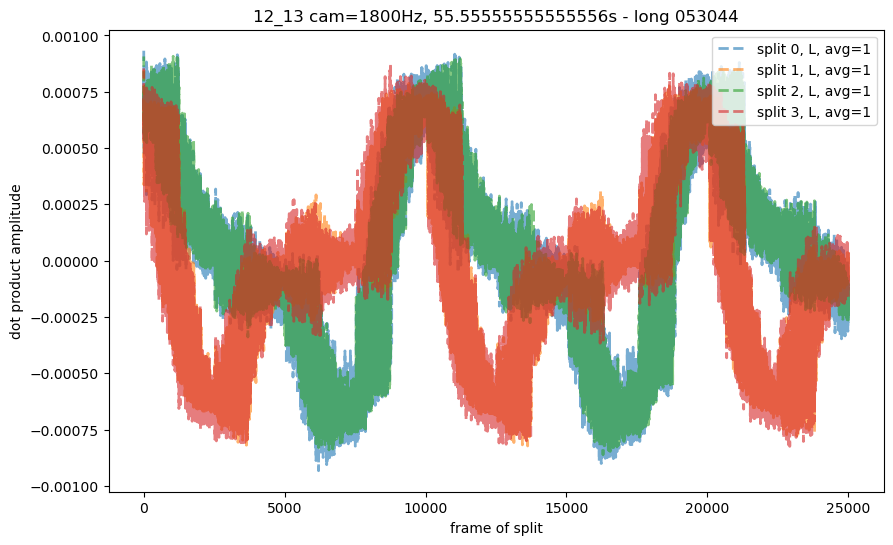

In [55]:
# compare lab with onsky datasets
fig = plt.figure(figsize=(10,6), facecolor='white')

for e, mat in enumerate(l_dot_avgs):
    plt.plot(l_dot_mat_first[e], lw=2, linestyle='dashed', alpha = 0.6, label = f'split {e}, L, avg=1')
    
plt.legend()
plt.xlabel('frame of split')
plt.ylabel('dot product amplitude')
plt.title(f"12_13 cam=1800Hz, {n/un_Hz}s - long 053044")
plt.show()

## Param Set 3: 

spark params: 1800,	1800,   20, 0.015,  0
<br>- 20221212 - HD15115 - 1:52
<br>- 20221212 - lab - 6:35 
<br>- selfRM_sparkles_20221211_12_008.fits